# Movie Recommendation System
### Eva Burns

## Problem Statement

Everyone has encountered this problem before: you sit down to watch a movie, have no idea what to watch or what you think you would like. To solve this, I will create a recommendation system using about 6 million ratings from 270,000 users. The recommendations for each user are created by predicting what the user will rate each movie, and recommending the highest predicted rated movies.

The dataset was found at [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) on Kaggle. This dataset consists of more files on the content information about the movies such as cast and crew, but I will focus on the following files for this recommender:

[movies_metadata.csv](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv): The main Movies Metadata file. Contains information on 45,000 movies found on TMDB. Relevant features include id, title, genres, popularity, vote_average, and vote_count

[ratings_small.csv](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings_small.csv): The subset of 100,000 ratings from 700 users on 9,000 movies. This is used for development and testing the model before using more data.

[ratings.csv](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv): The full 26 million ratings from 270,000 users for all 45,000 movies.

The ratings.csv file is too large for GitHub, so the data will have to be accessed from Kaggle.

## Assumptions/Hypotheses about data and model

Because ratings are user inputted, there are biases involved in the data. There are certain groups of people who may leave ratings on movies: critics and people who feel very strongly about the movie (both positively and negatively). For the purposes of this project, I will assume that the ratings are representative of the general population.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from ast import literal_eval
from zipfile import ZipFile
import os
import random
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
SOURCE_PATH = './data'

if (not os.path.exists(f'{SOURCE_PATH}/movies_metadata.csv')) | (not os.path.exists(f'{SOURCE_PATH}/ratings_small.csv')) | (not os.path.exists(f'{SOURCE_PATH}/ratings.csv')):
    zip = ZipFile(f'{SOURCE_PATH}/movie_data.zip')
    zip.extractall(path = SOURCE_PATH)
    zip.close()

    os.rmdir(f'{SOURCE_PATH}/__MACOSX')
    
movies_metadata = pd.read_csv(f'{SOURCE_PATH}/movies_metadata.csv', low_memory=False)
ratings_small = pd.read_csv(f'{SOURCE_PATH}/ratings_small.csv') # Used for testing and building purposes
ratings = pd.read_csv(f'{SOURCE_PATH}/ratings.csv')

In [3]:
# random.seed(123)
# ids = random.sample(list(set(ratings['userId'])), 1000)
# ratings_medium = ratings[ratings['userId'].isin(ids)] 
# len(ratings_medium)

### Data Cleaning

From the movies metadata dataset, I will drop some of the columns that will not be useful for this project.

In [4]:
movies_md = movies_metadata.copy()
movies_md = movies_md.drop(["homepage", "status", "video", "poster_path", "belongs_to_collection", 'adult', 'original_language', 'production_countries', 'original_title'], axis=1)

I also would like to convert the id column to int and the popularity column to float. However, there were some issues with the data imputation, and have some weird strings as a data point. Those will be made into null values and then dropped.

In [5]:
def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan

movies_md['popularity'] = movies_md['popularity'].apply(convert_float)
movies_md['id'] = movies_md['id'].apply(convert_float)

n_orig = len(movies_md['popularity'])

movies_md = movies_md[(movies_md['popularity'].notna()) & (movies_md['id'].notna())]
movies_md['id'] = movies_md['id'].astype(int)
n_new = len(movies_md['popularity'])

print(f"Number rows dropped: {n_orig - n_new}")

Number rows dropped: 6


I will also be evaluating the genres of the movies later, so I will convert them from a dictionary/json format to a list.

In [6]:
movies_md['genres'] = movies_md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Exploratory Data Analysis

I will begin by examining the most popular movies. A popularity score is calculated by TMDB basically by how much users interact with the movie (rating, viewing, favoriting, etc.)

In [7]:
simplified_md = movies_md[['id','title', 'popularity', 'genres']].sort_values(by='popularity', ascending=False)

grouped = ratings.groupby('movieId')

mean_ratings = grouped.mean()['rating']
num_ratings = grouped.count()['rating']

movie_ratings = pd.DataFrame({'avg_rating':mean_ratings, 'ratings_count': num_ratings}).reset_index()

simplified_md = simplified_md.merge(movie_ratings, left_on='id', right_on='movieId').drop('movieId', axis=1)

simplified_md.head(15)

,id,title,popularity,genres,avg_rating,ratings_count
0,680,Pulp Fiction,140.950236,"[Thriller, Crime]",3.552970,1246
1,155,The Dark Knight,123.167259,"[Drama, Action, Crime, Thriller]",3.395375,1319
2,78,Blade Runner,96.272374,"[Science Fiction, Drama, Thriller]",3.173709,1278
3,119450,Dawn of the Planet of the Apes,75.385211,"[Science Fiction, Action, Drama, Thriller]",3.000000,1
4,550,Fight Club,63.869599,[Drama],3.083261,3477
5,118340,Guardians of the Galaxy,53.291601,"[Action, Science Fiction, Adventure]",4.000000,1
6,278,The Shawshank Redemption,51.645403,"[Drama, Crime]",3.021647,1178
7,13,Forrest Gump,48.307194,"[Comedy, Drama, Romance]",3.326442,1838
8,22,Pirates of the Caribbean: The Curse of the Bla...,47.326665,"[Adventure, Fantasy, Action]",3.300608,11026
9,11,Star Wars,42.149697,"[Adventure, Action, Science Fiction]",3.660591,19475


Text(0.5, 1.0, 'Popular Movies')

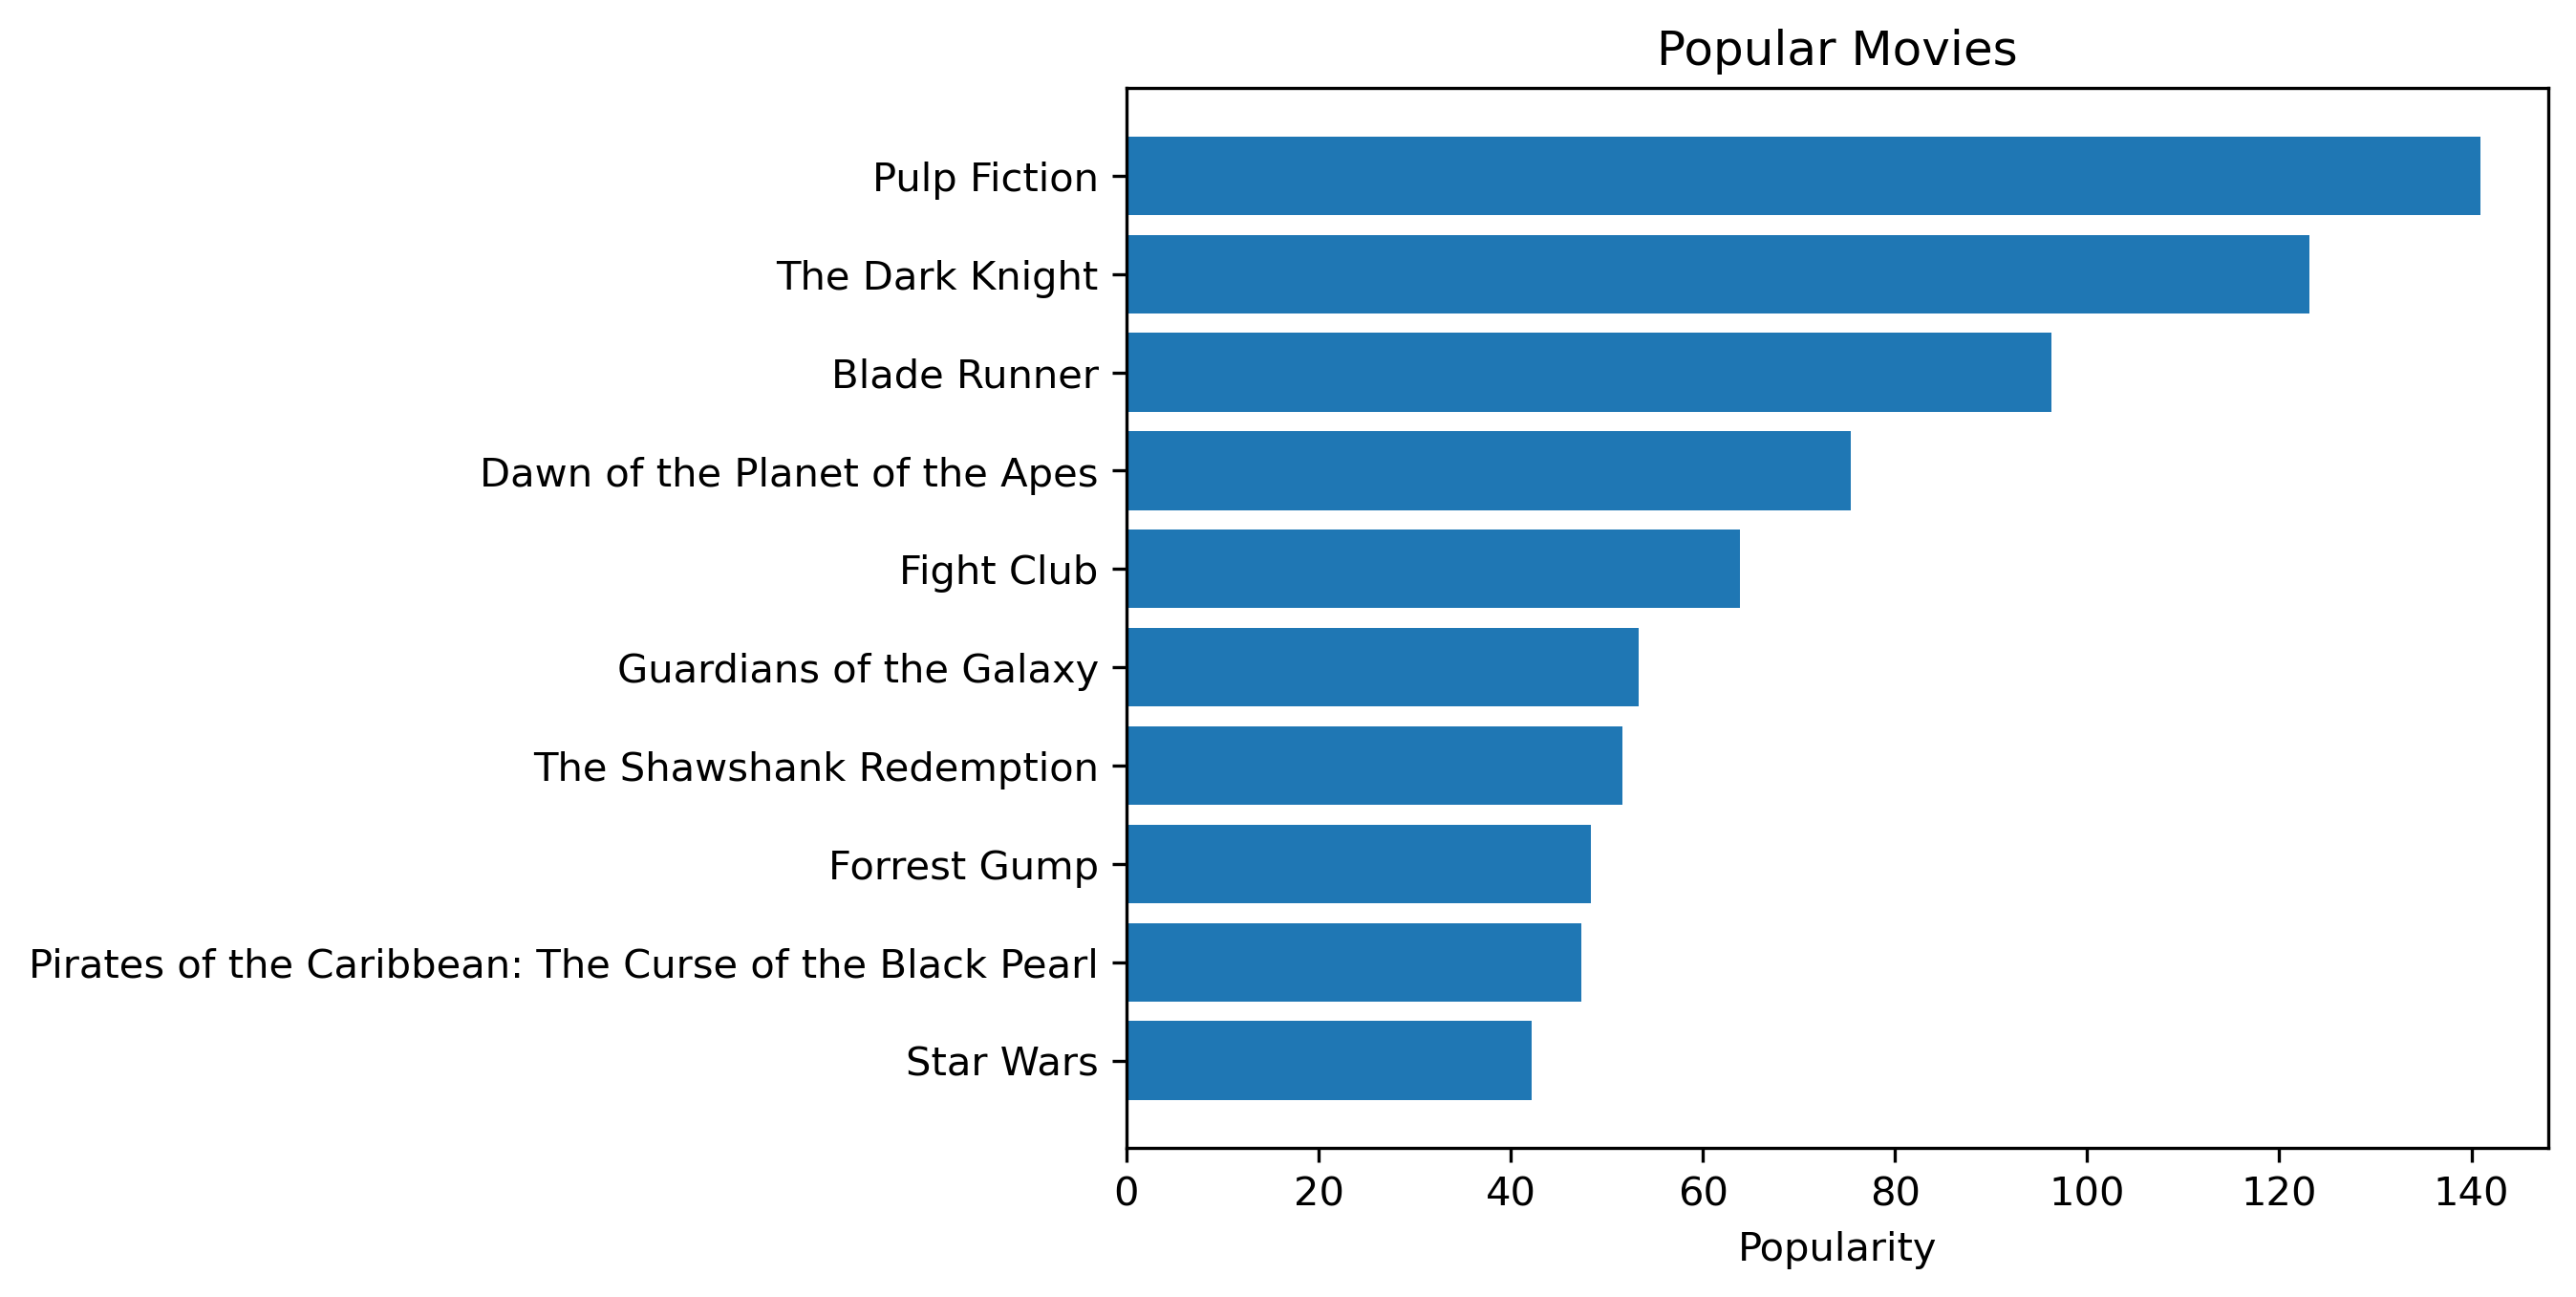

In [8]:
top_pop = simplified_md.head(10)

plt.barh(top_pop['title'],top_pop['popularity'])
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Below is the distribution of genres for the top 25 most popular movies.

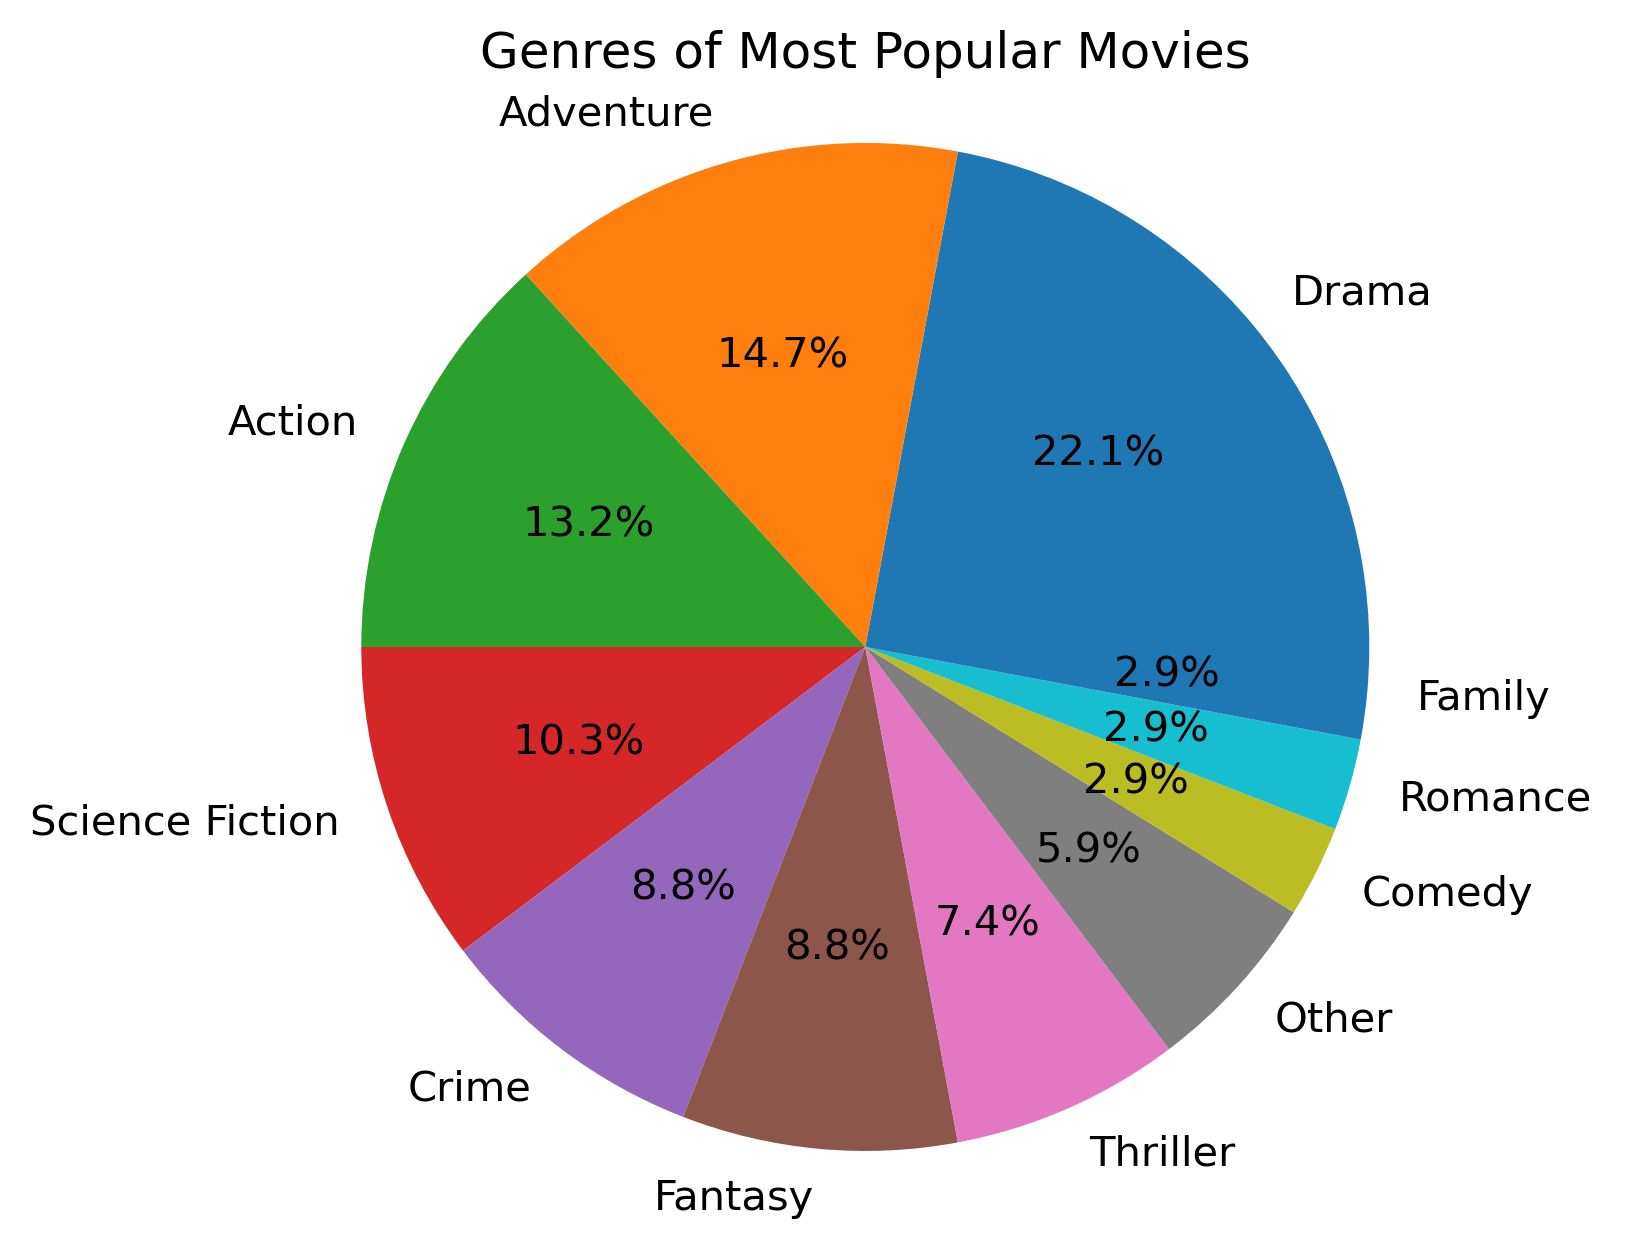

In [9]:
def count_genres(genre_series):
    total_ct = 0
    counts = dict()
    counts['Other'] = 0
    for genres in genre_series:
        for genre in genres:
            if genre not in counts.keys():
                counts[genre] = 1
            else: 
                counts[genre] += 1
            total_ct += 1
    
    for key in counts.keys():
        if counts[key] < .02 * total_ct:
            counts['Other'] += 1
            counts[key] = 0
    
    filtered_dict = {k:v for k,v in counts.items() if v != 0}
    return dict(sorted(filtered_dict.items(), key=lambda x:x[1], reverse=True))

popular_genres = count_genres(simplified_md.head(25)['genres'])

plt.pie(popular_genres.values(), labels=popular_genres.keys(), autopct='%1.1f%%')
plt.title("Genres of Most Popular Movies")
plt.axis('equal')
plt.show()

Now, I will examine the highest rated movies. I will do a few transformations to get a better idea of what is considered the highest rated movie. There are movies that only have one rating, so giving them the same weight as another movie with 10,000 ratings seems unreasonable. So first, I will filter out the movies in the lowest 10% of number of ratings. Then, I will calculate a weighted rating inspired by this formula used by IMDB:

$$\text{Weighted Rating (WR)} = \left( \frac{v}{v+m} \cdot R\right) + \left( \frac{m}{v+m} \cdot C\right)$$

$v$ is the number of votes for the movie

$m$ is the minimum votes required to be listed in the chart

$R$ is the average rating of the movie

$C$ is the mean vote across the whole report

In [10]:
C = simplified_md['avg_rating'].mean()
m = simplified_md['ratings_count'].quantile(0.9)

def weighted_rating(x, m=m, C=C):
    v = x['ratings_count']
    R = x['avg_rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

filtered_movies = simplified_md.copy().loc[simplified_md['ratings_count'] >= m]

filtered_movies['score'] = filtered_movies.apply(weighted_rating, axis=1)

filtered_movies = filtered_movies.sort_values(by="score", ascending=False)
filtered_movies.head(15)

,id,title,popularity,genres,avg_rating,ratings_count,score
2271,318,The Million Dollar Hotel,4.938231,"[Drama, Thriller]",4.429015,91082,4.382976
925,858,Sleepless in Seattle,10.234919,"[Comedy, Drama, Romance]",4.339811,57070,4.272782
2526,527,Once Were Warriors,4.025276,[Drama],4.266531,67662,4.212948
1680,2959,License to Wed,7.102076,[Comedy],4.230716,60024,4.172561
72,296,Terminator 3: Rise of the Machines,20.818907,"[Action, Thriller, Science Fiction]",4.169975,87901,4.131812
768,593,Solaris,11.059785,"[Drama, Science Fiction, Adventure, Mystery]",4.152246,84078,4.113090
1091,912,The Thomas Crown Affair,9.444818,"[Romance, Crime, Thriller, Drama]",4.214393,30043,4.105640
4844,58559,Confession of a Child of the Century,0.778480,[Drama],4.182071,39600,4.100037
1638,750,Murder She Said,7.261845,"[Drama, Crime, Mystery, Comedy]",4.213030,28280,4.098358
2028,260,The 39 Steps,5.865697,"[Action, Thriller, Mystery]",4.132299,77045,4.090546


Text(0.5, 1.0, 'High Scoring Movies')

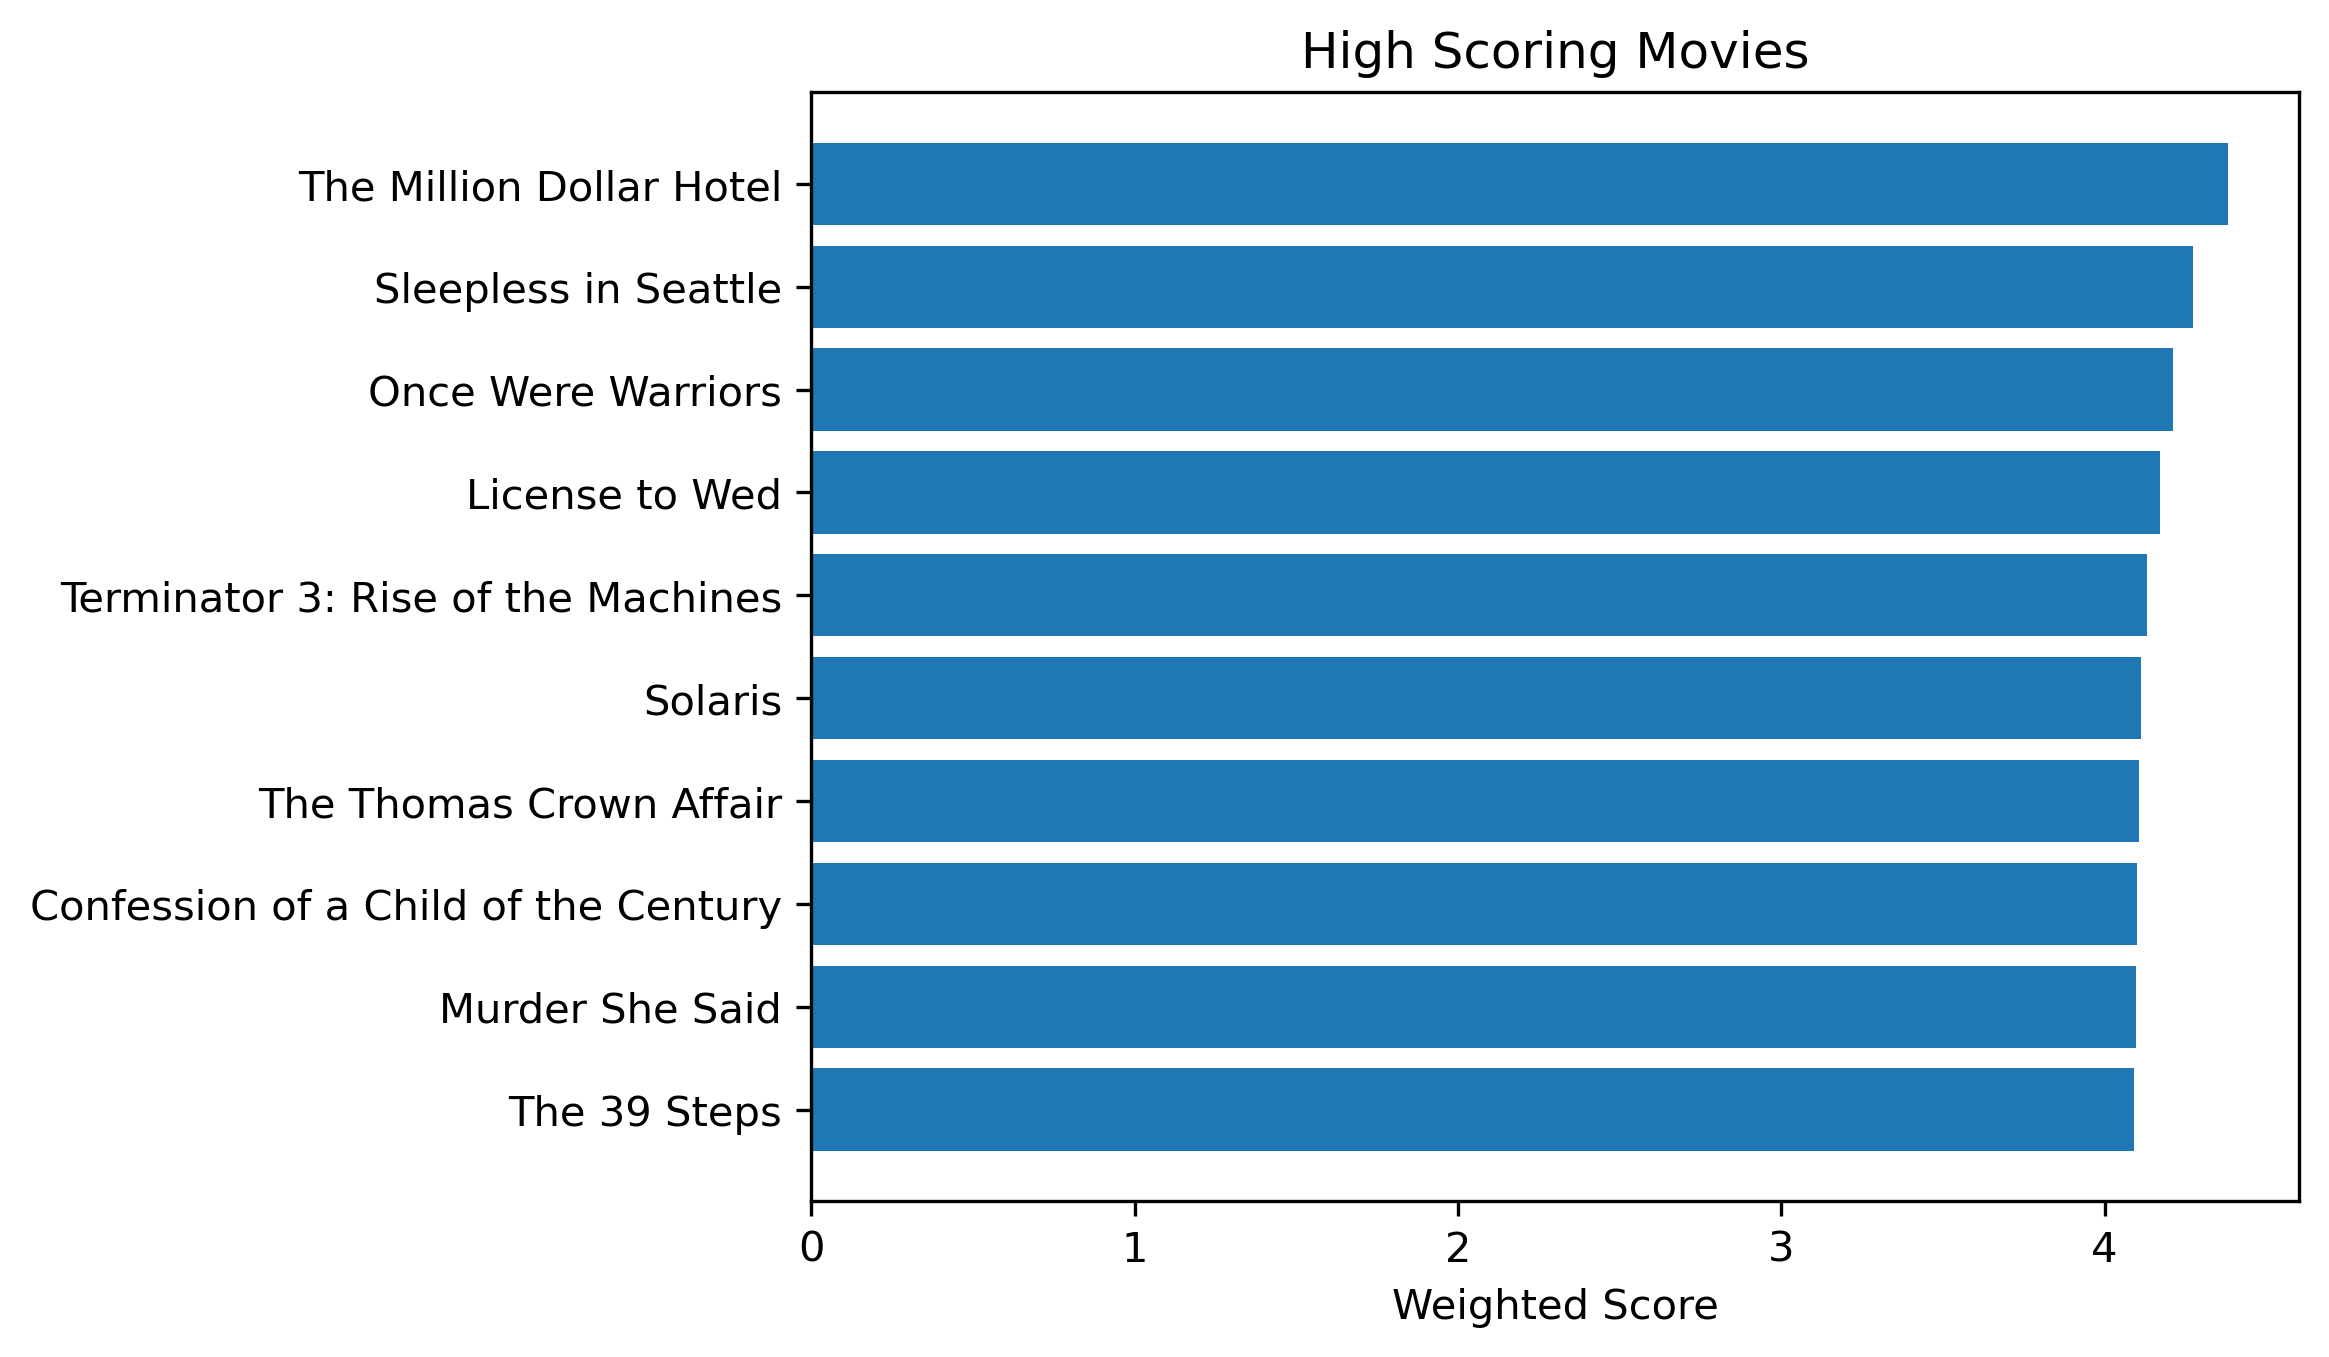

In [11]:
top_score = filtered_movies.head(10)

plt.barh(top_score['title'],top_score['score'])
plt.gca().invert_yaxis()
plt.xlabel("Weighted Score")
plt.title("High Scoring Movies")

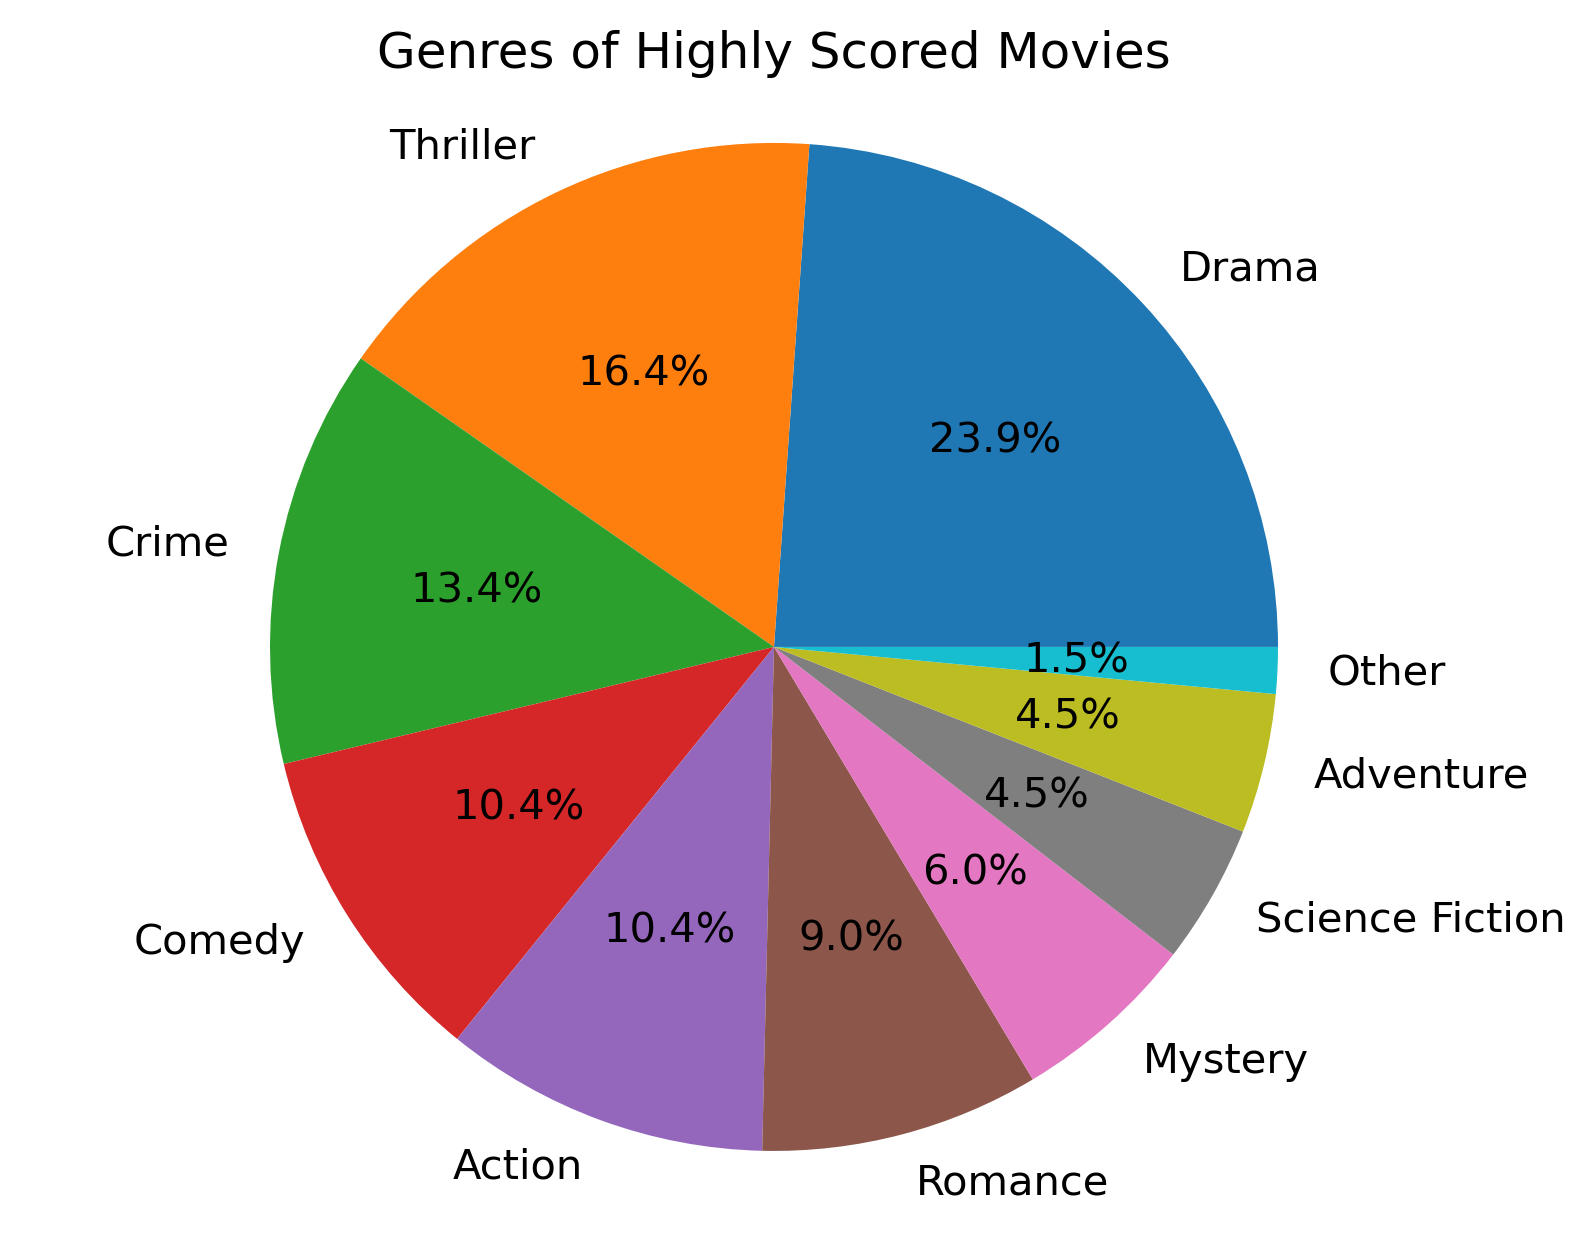

In [12]:
high_score_genres = count_genres(filtered_movies.head(25)['genres'])

plt.pie(high_score_genres.values(), labels=high_score_genres.keys(), autopct='%1.1f%%')
plt.title("Genres of Highly Scored Movies")
plt.axis('equal')
plt.show()

## Feature Engineering & Transformations

There are no transformations needed for the model I will use for this project. All I have to do is convert the ratings data into a readable format for the model I will use which I will explain in the next section. The `Reader` and `Dataset.load_from_df` comes from the `surprise` package where the data is converted to a list of tuples.

In [13]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.raw_ratings[0:10]

[(1, 110, 1.0, None),
 (1, 147, 4.5, None),
 (1, 858, 5.0, None),
 (1, 1221, 5.0, None),
 (1, 1246, 5.0, None),
 (1, 1968, 4.0, None),
 (1, 2762, 4.5, None),
 (1, 2918, 5.0, None),
 (1, 2959, 4.0, None),
 (1, 4226, 4.0, None)]

## Proposed Approaches (Model)

### Single Value Decomposition

In a previous homework assignment, we used Collabrative Filtering (CF) to build a recommendations system. However, CF has a couple issues. The primary challenge at hand is scalability, where the computational demands increase as the number of users and movies grows. Furthermore, sparsity poses another issue. In certain scenarios, there could be millions of users, and the similarity between two seemingly dissimilar movies might be remarkably high due to the presence of a single user who ranked them both similarly.

One approach to address the scalability and sparsity challenges posed by CF is to utilize a latent factor model to capture the similarity between users and items. The aim is to transform the recommendation problem into an optimization problem, specifically focusing on accurately predicting movie ratings for a given user.

Latent factors encompasses the inherent properties or concepts associated with users or movies. For this project, the latent factor represents the rating the users gave the movies. Through Singular Value Decomposition (SVD), we reduce the dimensionality of the utility matrix by extracting its latent factors. This process involves mapping each user and movie onto a latent space with a dimension of 'r'. Consequently, it facilitates a more meaningful understanding of the relationship between users and movies, making them directly comparable.

This SVD model was built using the [Surprise package](https://surpriselib.com/).

Hug, N., (2020). Surprise: A Python library for recommender systems. Journal of Open Source Software, 5(52), 2174, https://doi.org/10.21105/joss.02174

In [14]:
svd = SVD()

## Proposed Solution (Model Selection)

To train the model, I will employ a cross validation of 5 folds, using RMSE and MAE as accuracy metrics.

In [15]:
import time
start = time.time()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

end = time.time()
print(f"\nTime elasped: {round(end-start, 3)} seconds ({round(len(ratings)/(end-start), 3)} ratings per second)")

trainset = data.build_full_trainset()
testset = trainset.build_testset()

predictions = svd.test(testset)

rmse = accuracy.rmse(predictions, verbose=False) 
mse = accuracy.mse(predictions, verbose=False) 
mae = accuracy.mae(predictions, verbose=False) 

svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7958  0.7959  0.7964  0.7967  0.7962  0.7962  0.0004  
MAE (testset)     0.6018  0.6021  0.6023  0.6026  0.6022  0.6022  0.0003  
Fit time          185.94  385.93  365.98  394.30  344.17  335.26  76.65   
Test time         152.14  121.58  140.40  127.49  118.78  132.08  12.49   

Time elasped: 3240.326 seconds (8031.38 ratings per second)


Now that I have a model that will predict what a user will rate a specific movie, I will now create a list of recommended movies for a given user based on what the SVD predict will be their highest rated movies. 

I do this by going through every movie in the database, and getting the predicted rating for that user/movie pairing. Once I have done that for every movie, I will sort the ratings so that the highest predicted rated movie is recommended to the user. Note that all movies the user has already rated have been excluded from the list. I will demonstrate the recommender in the next section.

In [16]:
def get_recommendations_for_user(user_id):
    est_ratings = []
    for i, row in filtered_movies.iterrows():
        movie_id = int(row['id'])
        title = row['title']
        est_rat = svd.predict(user_id, movie_id).est
        est_ratings += [[movie_id, row['title'], est_rat, row['genres']]]

    recommendation = pd.DataFrame(est_ratings, columns=["movieId", "title", "estimated_rating", 'genres'])
    recommendation = recommendation[~recommendation['movieId'].isin(ratings[ratings['userId'] == user_id]['movieId'])]
    
    return recommendation.sort_values(by='estimated_rating', ascending=False)

## Results (Accuracy) and Learnings from the methodology

I will evaluate the accuracy of the model on the test set using RMSE, MSE, MAE. The model predicts what the user will rate a movie, so I can calculate how accurate the SVD model is on movies that have already been rated. 

In [17]:
print("RMSE:", round(rmse, 4))
print("MSE:", round(mse, 4))
print("MAE:", round(mae, 4))

RMSE: 0.7031
MSE: 0.4943
MAE: 0.5338


The accuracy metrics are quite low for this type of model, so I believe it is sucessfully predicting user ratings. There is always room for improvement, though.

### Example user recommendation

I've chosen User 1 to demonstrate the recommender. Below is what they have rated the movies they have watched, sorted by rating.

In [18]:
user_id = 1

user_hist = ratings[ratings['userId'] == user_id].merge(movies_md[['id', 'title', 'genres']], left_on='movieId', right_on="id")
user_hist = user_hist.sort_values(by='rating', ascending=False)
user_hist

,userId,movieId,rating,timestamp,id,title,genres
2,1,858,5.0,1425941523,858,Sleepless in Seattle,"[Comedy, Drama, Romance]"
3,1,1246,5.0,1425941556,1246,Rocky Balboa,[Drama]
10,1,96821,5.0,1425941382,96821,Caesar Must Die,"[Drama, Documentary]"
1,1,147,4.5,1425942435,147,The 400 Blows,[Drama]
5,1,2762,4.5,1425941300,2762,Young and Innocent,"[Drama, Crime]"
4,1,1968,4.0,1425942148,1968,Fools Rush In,"[Drama, Comedy, Romance]"
6,1,2959,4.0,1425941601,2959,License to Wed,[Comedy]
7,1,4226,4.0,1425942228,4226,Shriek If You Know What I Did Last Friday the ...,[Comedy]
9,1,58559,4.0,1425942007,58559,Confession of a Child of the Century,[Drama]
8,1,54503,3.5,1425941313,54503,The Mystery of Chess Boxing,"[Action, Foreign]"


Now, I will use my recommender to recommend 10 movies to the user using the method described above.

In [20]:
user_rec = get_recommendations_for_user(user_id).head(10)
user_rec

,movieId,title,estimated_rating,genres
71,306,Beverly Hills Cop III,5.000000,"[Action, Comedy, Crime]"
36,44555,"A Woman, a Gun and a Noodle Shop",4.904216,"[Comedy, Drama, Thriller]"
101,307,"Rome, Open City",4.895459,"[Drama, History]"
212,28,Apocalypse Now,4.848280,"[Drama, War]"
53,17,The Dark,4.840669,"[Horror, Thriller, Mystery]"
67,246,Zatoichi,4.793591,"[Adventure, Drama, Action]"
161,2064,While You Were Sleeping,4.784361,"[Comedy, Drama, Romance]"
47,5971,We're No Angels,4.777725,"[Comedy, Crime, Drama]"
18,2019,Hard Target,4.757174,"[Action, Adventure, Crime, Thriller]"
146,3089,Red River,4.756867,[Western]


The highest estimated rating was 5 for Bevery Hills Cop III for User 1. Comparing the genre breakdown of User 1's actual ratings versus the recommended movies makes sense. The user liked dramas and comedies the most, which is reflected in the recommended movies.

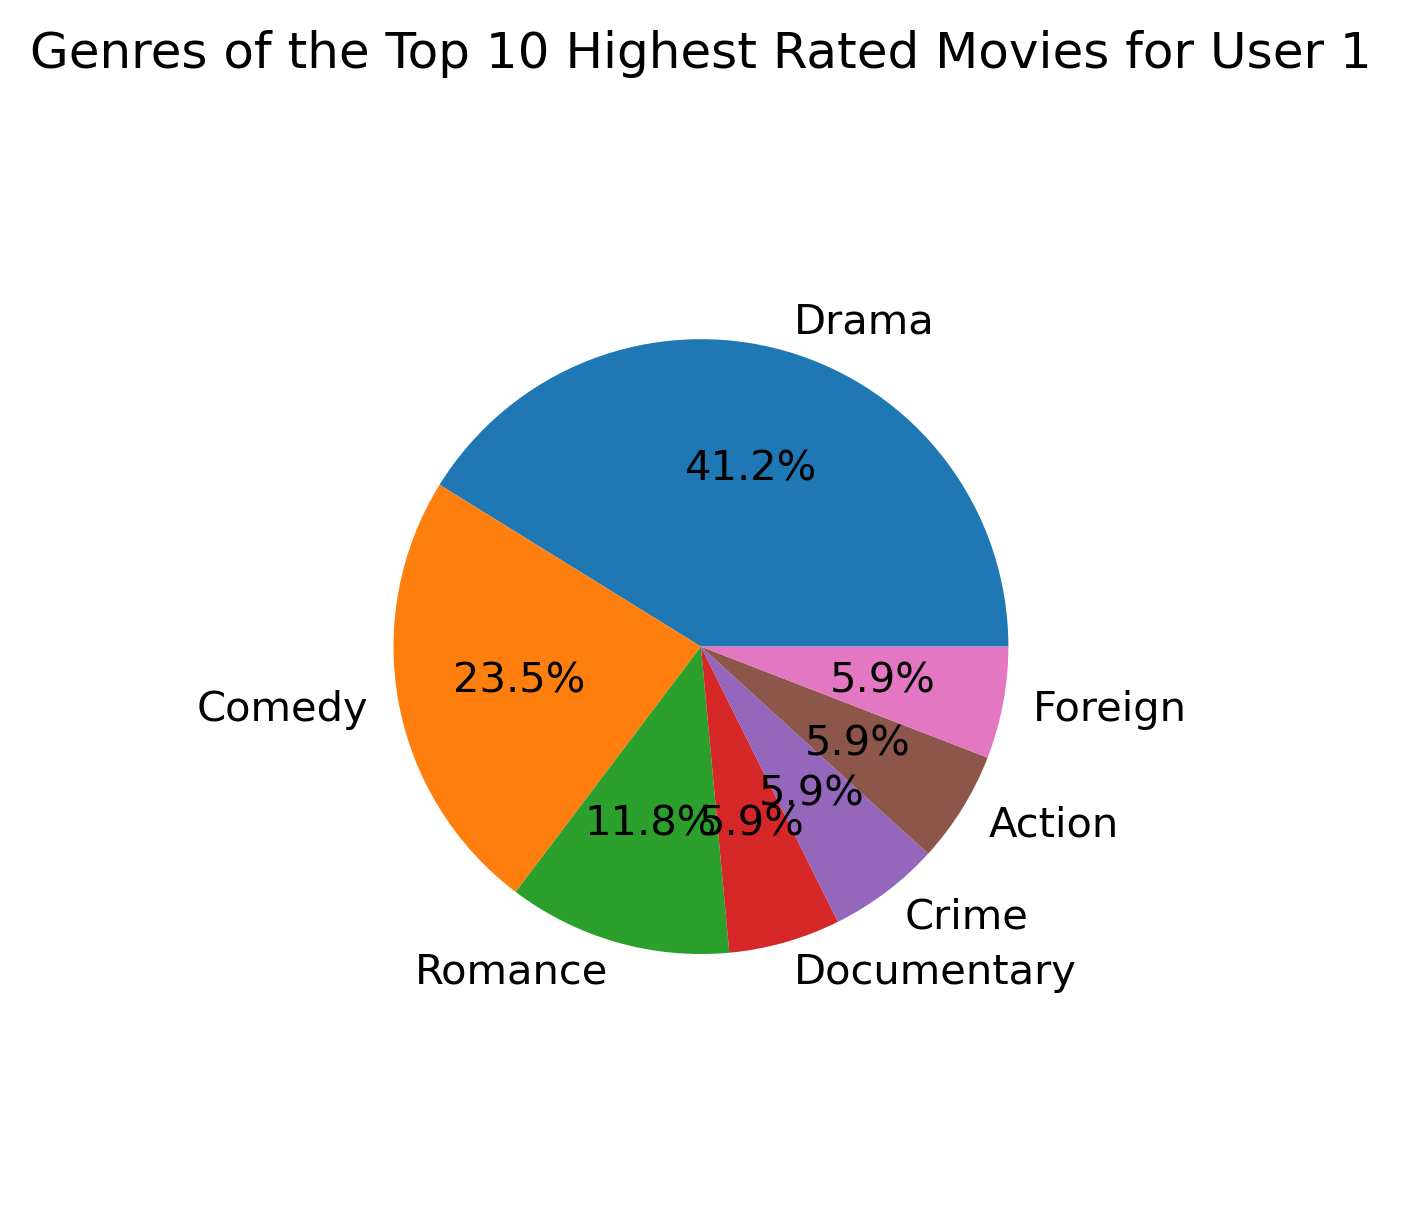

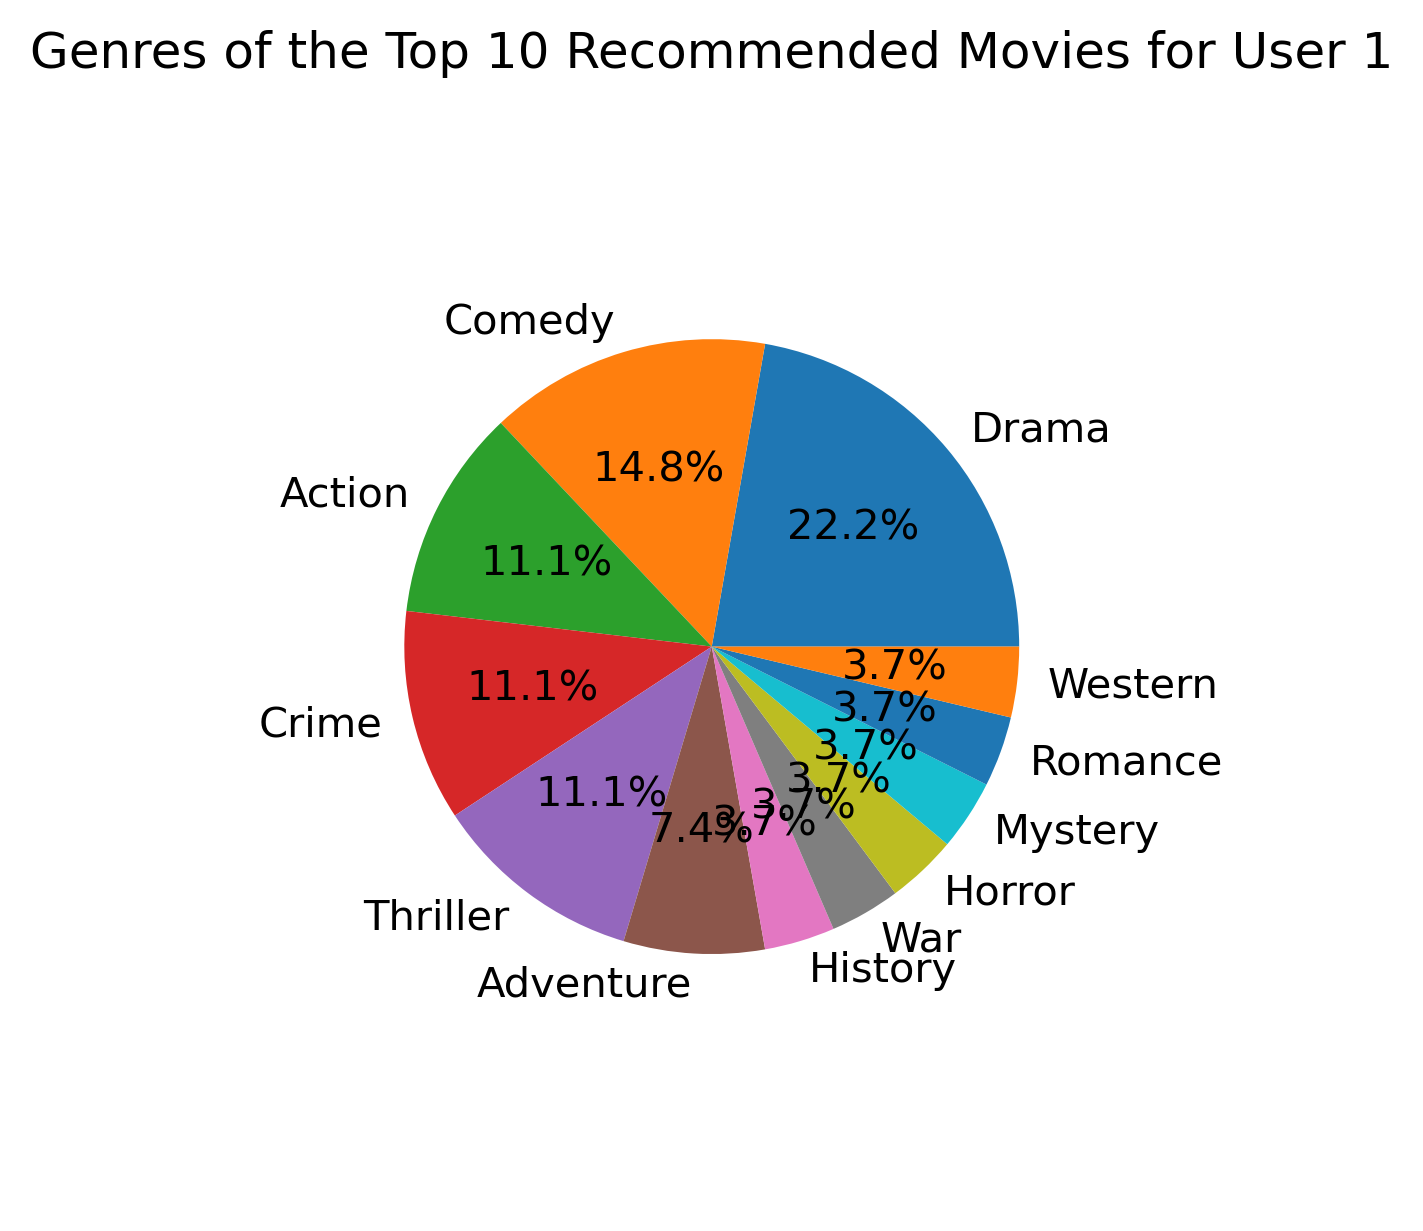

In [26]:
if len(user_hist) < 10:
    user_genre_count = count_genres(user_hist['genres'])
else:
    user_genre_count = count_genres(user_hist.head(10)['genres'])

plt.subplot(1, 2, 1)
plt.pie(user_genre_count.values(), labels=user_genre_count.keys(), autopct='%1.1f%%')
plt.title(f"Genres of the Top 10 Highest Rated Movies for User {user_hist.iloc[0,0]}")
plt.axis('equal')
plt.show()

rec_genre_count = count_genres(user_rec['genres'])

plt.subplot(1, 2, 2)
plt.pie(rec_genre_count.values(), labels=rec_genre_count.keys(), autopct='%1.1f%%')
plt.title(f"Genres of the Top 10 Recommended Movies for User {user_hist.iloc[0,0]}")
plt.axis('equal')
plt.show()

## Future Work

There was a good portion of the data from kaggle I did not use, mainly information about the movies such as cast, crew, keywords from the description, and genre. Next steps would be to make a hybrid recommender that incorporates the svd model already made with some of the movie information. For example, based on the movies the user gave a high rating for, find movies that other users also liked (SVD). Then, find movies that have similar plots, cast, or genre to the movies the user already liked.

I think incorporating these multiple aspects could make an even more accurate recommender.

Another note is that the highest recommended movie for User 1 was Beverly Hills Cop III, which is a sequel. User 1 has not seen the original movies, so it does not make sense to recommend that movie. An adjustment to the recommender should be made to filter out sequels if the user has not seen the movies before it.

In [22]:
os.remove(f'{SOURCE_PATH}/movies_metadata.csv')
os.remove(f'{SOURCE_PATH}/ratings_small.csv')
os.remove(f'{SOURCE_PATH}/ratings.csv')